100%|█████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:59<00:00, 338.78it/s]


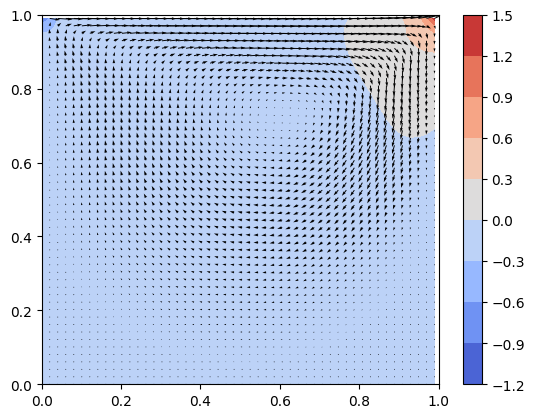

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

N_POINTS = 100
DOMAIN_SIZE = 1.0
N_ITERATIONS = 20000
TIME_STEP_LENGTH = 0.001
Re = 100
KINEMATIC_VISCOSITY = 1/Re
DENSITY = 1.0
HORIZONTAL_VELOCITY_TOP = 1.0

N_PRESSURE_POISSON_ITERATIONS = 50
STABILITY_SAFETY_FACTOR = 0.5


element_length = DOMAIN_SIZE / (N_POINTS - 1)
x = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)
y = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)

X, Y = np.meshgrid(x, y)

u_prev = np.zeros_like(X)
v_prev = np.zeros_like(X)
p_prev = np.zeros_like(X)


def central_difference_x(f):
    diff = np.zeros_like(f)
    diff[1:-1, 1:-1] = (
        f[1:-1, 2:  ]
        -
        f[1:-1, 0:-2]
    ) / (
        2 * element_length
    )
    return diff

def central_difference_y(f):
    diff = np.zeros_like(f)
    diff[1:-1, 1:-1] = (
        f[2:  , 1:-1]
        -
        f[0:-2, 1:-1]
    ) / (
        2 * element_length
    )
    return diff

def laplace(f):
    diff = np.zeros_like(f)
    diff[1:-1, 1:-1] = (
        f[1:-1, 0:-2]
        +
        f[0:-2, 1:-1]
        -
        4
        *
        f[1:-1, 1:-1]
        +
        f[1:-1, 2:  ]
        +
        f[2:  , 1:-1]
    ) / (
        element_length**2
    )
    return diff


maximum_possible_time_step_length = (
    0.5 * element_length**2 / KINEMATIC_VISCOSITY
)
if TIME_STEP_LENGTH > STABILITY_SAFETY_FACTOR * maximum_possible_time_step_length:
    raise RuntimeError("Stability is not guarenteed")


for _ in tqdm(range(N_ITERATIONS)):
    d_u_prev__d_x = central_difference_x(u_prev)
    d_u_prev__d_y = central_difference_y(u_prev)
    d_v_prev__d_x = central_difference_x(v_prev)
    d_v_prev__d_y = central_difference_y(v_prev)
    laplace__u_prev = laplace(u_prev)
    laplace__v_prev = laplace(v_prev)

    # Perform a tentative step by solving the momentum equation without the
    # pressure gradient
    u_tent = (
        u_prev
        +
        TIME_STEP_LENGTH * (
            -
            (
                u_prev * d_u_prev__d_x
                +
                v_prev * d_u_prev__d_y
            )
            +
            KINEMATIC_VISCOSITY * laplace__u_prev
        )
    )
    v_tent = (
        v_prev
        +
        TIME_STEP_LENGTH * (
            -
            (
                u_prev * d_v_prev__d_x
                +
                v_prev * d_v_prev__d_y
            )
            +
            KINEMATIC_VISCOSITY * laplace__v_prev
        )
    )

    # Velocity Boundary Conditions: Homogeneous Dirichlet BC everywhere
    # except for the horizontal velocity at the top, which is prescribed
    u_tent[0, :] = 0.0
    u_tent[:, 0] = 0.0
    u_tent[:, -1] = 0.0
    u_tent[-1, :] = HORIZONTAL_VELOCITY_TOP
    v_tent[0, :] = 0.0
    v_tent[:, 0] = 0.0
    v_tent[:, -1] = 0.0
    v_tent[-1, :] = 0.0


    d_u_tent__d_x = central_difference_x(u_tent)
    d_v_tent__d_y = central_difference_y(v_tent)

    # Compute a pressure correction by solving the pressure-poisson equation
    rhs = (
        DENSITY / TIME_STEP_LENGTH
        *
        (
            d_u_tent__d_x
            +
            d_v_tent__d_y
        )
    )

    for _ in range(N_PRESSURE_POISSON_ITERATIONS):
        p_next = np.zeros_like(p_prev)
        p_next[1:-1, 1:-1] = 1/4 * (
            +
            p_prev[1:-1, 0:-2]
            +
            p_prev[0:-2, 1:-1]
            +
            p_prev[1:-1, 2:  ]
            +
            p_prev[2:  , 1:-1]
            -
            element_length**2
            *
            rhs[1:-1, 1:-1]
        )

        # Pressure Boundary Conditions: Homogeneous Neumann Boundary
        # Conditions everywhere except for the top, where it is a
        # homogeneous Dirichlet BC
        p_next[:, -1] = p_next[:, -2]
        p_next[0,  :] = p_next[1,  :]
        p_next[:,  0] = p_next[:,  1]
        p_next[-1, :] = 0.0

        p_prev = p_next


    d_p_next__d_x = central_difference_x(p_next)
    d_p_next__d_y = central_difference_y(p_next)

    # Correct the velocities such that the fluid stays incompressible
    u_next = (
        u_tent
        -
        TIME_STEP_LENGTH / DENSITY
        *
        d_p_next__d_x
    )
    v_next = (
        v_tent
        -
        TIME_STEP_LENGTH / DENSITY
        *
        d_p_next__d_y
    )

    # Velocity Boundary Conditions: Homogeneous Dirichlet BC everywhere
    # except for the horizontal velocity at the top, which is prescribed
    u_next[0, :] = 0.0
    u_next[:, 0] = 0.0
    u_next[:, -1] = 0.0
    u_next[-1, :] = HORIZONTAL_VELOCITY_TOP
    v_next[0, :] = 0.0
    v_next[:, 0] = 0.0
    v_next[:, -1] = 0.0
    v_next[-1, :] = 0.0


    # Advance in time
    u_prev = u_next
    v_prev = v_next
    p_prev = p_next


# The [::2, ::2] selects only every second entry (less cluttering plot)
plt.figure()
plt.contourf(X[::2, ::2], Y[::2, ::2], p_next[::2, ::2], cmap="coolwarm")
plt.colorbar()

plt.quiver(X[::2, ::2], Y[::2, ::2], u_next[::2, ::2], v_next[::2, ::2], color="black")
# plt.streamplot(X[::2, ::2], Y[::2, ::2], u_next[::2, ::2], v_next[::2, ::2], color="black")
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

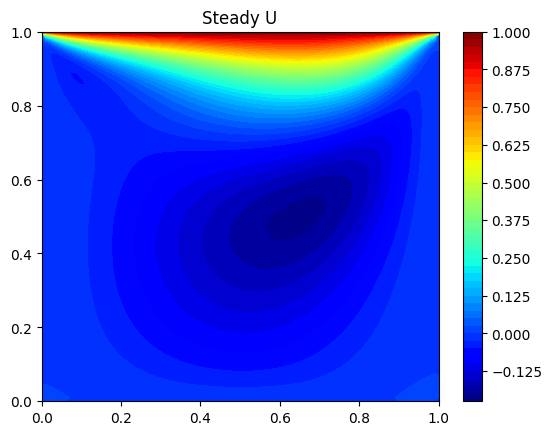

In [25]:
plt.figure()
plt.contourf(X, Y, u_next, 50, cmap='jet')
plt.colorbar()
# plt.axis([0, 1, 0, 1])
plt.title("Steady U")
plt.show()

In [9]:
GhiaU = np.loadtxt('./benchmark/GhiaU.txt', skiprows=1)
GhiaV = np.loadtxt('./benchmark/GhiaV.txt', skiprows=1)
y_Ghia = GhiaU[:, 0]
x_Ghia = GhiaV[:, 0]

In [4]:
# Understand what's inside the benchmark data
import pandas as pd
# pd.set_option('display.max_columns', None)
df = pd.read_table("./benchmark/GhiaU.txt", skiprows=0, delimiter='\r')
print(df)

   # Ghia, U. K. N. G., Ghia, K. N., & Shin, C. T. (1982). 
0   # High-Re solutions for incompressible flow us...      
1   # Journal of computational physics, 48(3), 387...      
2                                                   #      
3                                           # TABLE I      
4   # Results for $u$-velocity along Vertical Line...      
5   #---------------------------------------------...      
6              #                                   Re      
7   #       --------------------------------------...      
8   #  y      100      400      1000     3200     ...      
9   #---------------------------------------------...      
10  1.0000  1.00000  1.00000  1.00000  1.00000  1....      
11  0.9766  0.84123  0.75837  0.65928  0.53236  0....      
12  0.9688  0.78871  0.68439  0.57492  0.48296  0....      
13  0.9609  0.73722  0.61756  0.51117  0.46547  0....      
14  0.9531  0.68717  0.55892  0.46604  0.46101  0....      
15  0.8516  0.23151  0.29093  0.33304  0

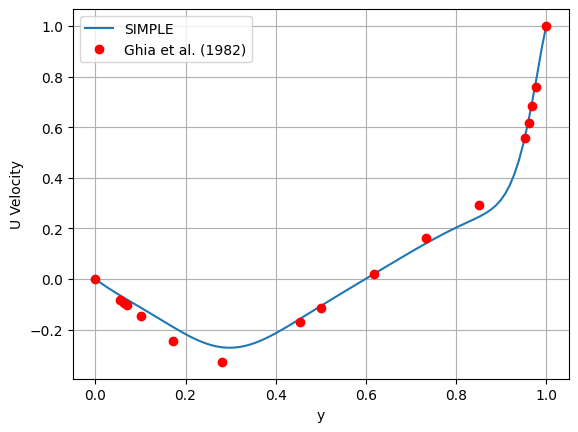

In [21]:
plt.plot(y, u_next[:,50], label="SIMPLE")
plt.plot(y_Ghia, GhiaU[:, 2], 'ro', label = "Ghia et al. (1982)")
plt.grid()
plt.xlabel("y")
plt.ylabel("U Velocity")
# plt.title("Velocity along $y$-axis $x=0.5$, Re = {0}, Grid: {1}x{2}".format(Re, imax, jmax))
plt.legend()
# plt.savefig("./Benchmark/Re{0}/UBench_Re{0}_Grid{1}x{2}.png".format(Re, imax, jmax), dpi=500)

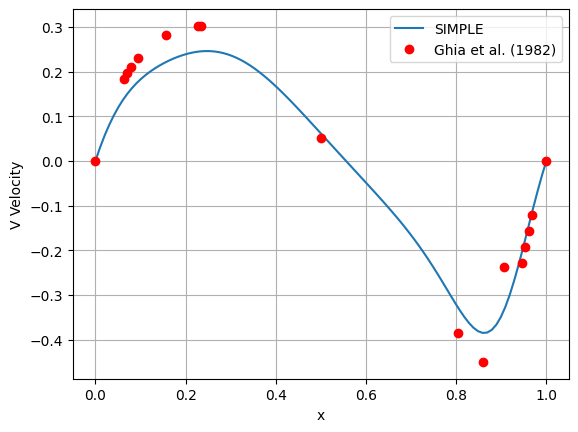

In [22]:
v_profile = v_next[50,:]
plt.plot(x, v_profile, label="SIMPLE")
plt.plot(x_Ghia, GhiaV[:, 2], 'ro', label = "Ghia et al. (1982)")
plt.grid()
plt.xlabel("x")
plt.ylabel("V Velocity")
plt.legend()